## Conteo de acusaciones en el Congreso de los Diputados
Contamos el número de acusaciones en la totalidad de Diarios de Sesiones del Congreso con el fin de estudiar la polarización y crispación política.

Utilizaremos el LLM, mistral-large, para evaluar lo que es una intervención. También tendremos en cuenta el año de la intervención y grupo político y género del orador. 

### Prompt para detectar acusaciones
Entendemos como acusación como una declaración en la que se atribuye una cualidad o actitud negativa a una persona o grupo de personas.

Diseñamos un prompt para mistral_large que clasifica si una frase es una acusación de forma binaria y clasificamos de forma manual 71 frases para comprobar su eficacia.

        Dime si en la siguiente frase hay una acusación. Responde con 1 si la hay. Responde con 0 si no la hay.

        Ejemplos:
        Input: Ustedes son unos ladrones.
        Output: 1
        Input: Venimos a proponer la siguiente enmienda a la ley numero 3.01.
        Output: 0

        Input: FRASE A ANALIZAR
        Output:

Tras clasificar con el prompt las 71 frases de prueba, obtenemos una precisión del 78,9%. Debido al gran número de frases que vamos a clasificar en nuestro corpus, aceptamos esta precisión como válida.

In [7]:
import pandas as pd

dir =  r"C:\Users\acent\Academico\proyecto-excelencia\parte-practica\database\fine_data.csv"
df = pd.read_csv(dir)

In [8]:
df

,text,group,gender,year,mistral_large,nfrases,acusacion
0,"Señoras y señores Diputados, se abre la sesión...",PP,Male,1979,0,3,0.000000
1,Según la relación que consta en la Secretaría ...,PP,Male,1979,0,9,0.000000
2,"Siguiendo el orden del día, ruego al señor Esp...",PSOE,Male,1979,0,4,0.000000
3,Señoras y señores Diputados. en nombre de la M...,PSOE,Male,1979,0,18,0.000000
4,"Al reanudarse la sesión, procedería dar lectur...",PSOE,Male,1979,0,7,0.000000
...,...,...,...,...,...,...,...
144204,"Muchas gracias, señora presidenta. Buenas tard...",VOX,Male,2024,15,45,33.333333
144205,"Muchas gracias, presidenta. Buenas tardes, señ...",PP,Male,2024,30,84,35.714286
144206,"Buenas tardes, noches ya, señorías. Probableme...",IU-PODEMOS,Male,2024,22,51,43.137255
144207,"Gracias, presidenta. Buenas tardes, señorías. ...",PSOE,Female,2024,9,37,24.324324


<h4>Agrupaciones políticas</h4>

Distingimos las diferentes formas de agrupar todos los grupos políticos presentes.

In [9]:
partidos = ["VOX", "PP", "PSOE", "IU-PODEMOS"]
partidos_hombres = [agrupacion + " - Male" for agrupacion in partidos]
partidos_mujeres = [agrupacion + " - Female" for agrupacion in partidos]
indexes = []

for a in partidos:
    indexes.append(a)
for a in partidos_hombres:
    indexes.append(a)
for a in partidos_mujeres:
    indexes.append(a)

El rango de años estudiado es la primera sesión parlamentaria de la primera legislatura en 1979 hasta la cuadragésimo tercera sesión de la quinceava legislatura, el 28 de mayo de 2024.

    (1979-2024)

In [10]:
years = []
year = 1979
while (year <= 2024):
    years.append(year)
    year+=1

## \% de acusación de una intervención

Para evaluar qué tanto por ciento de una intervención está compuesta por intervenciones debemos dividirla en frases. Nosotros lo hemos hecho usando el analizador de spacy en español. Después, debemos evaluar cada frase usando el prompt. Nuestro tanto por ciento de acusación es el número de acusaciones dividido entre el número de frases multiplicado por cien.

Con el fin de agilizar los cálculos, creamos una estructura de datos que agrupe el número total de acusaciones de cada grupo, por cada género, cada año y otra con el número total de acusaciones.

In [11]:
acusaciones = {}
frases = {}
for year in years:
    acusaciones[year] = {}
    frases[year] = {}
    for index in indexes:
        acusaciones[year][index] = 0
        frases[year][index] = 0

for index, interv in df.iterrows():
    year = interv["year"]
    acus = interv["mistral_large"]
    fras = interv["nfrases"]

    acusaciones[year][f"{interv["group"]} - {interv["gender"]}"] += acus
    acusaciones[year][interv["group"]] += acus
    frases[year][f"{interv["group"]} - {interv["gender"]}"] += fras
    frases[year][interv["group"]] += fras


In [12]:
acusaciones[2019]["PP"]

1163

Con estos diccionarios es muy rápido computar un dataframe cuyos índices sean los años y columnas los grupos (segregando por género)

In [13]:
df_acusaciones = pd.DataFrame(acusaciones).T
df_frases = pd.DataFrame(frases).T

df_acusaciones["Total - Male"] = df_acusaciones[partidos_hombres].sum(axis=1)
df_acusaciones["Total - Female"] = df_acusaciones[partidos_mujeres].sum(axis=1)
df_acusaciones["Total"] = df_acusaciones["Total - Male"] + df_acusaciones["Total - Female"]

df_frases["Total - Male"] = df_frases[partidos_hombres].sum(axis=1)
df_frases["Total - Female"] = df_frases[partidos_mujeres].sum(axis=1)
df_frases["Total"] = df_frases["Total - Male"] + df_acusaciones["Total - Female"]

df_frases = df_frases.replace(0, 1) # Para evitar dividir por 0. 

df = df_acusaciones / df_frases * 100

display(df_acusaciones.head())
display(df_frases.head())
display(df.head())

,VOX,PP,PSOE,IU-PODEMOS,VOX - Male,PP - Male,PSOE - Male,IU-PODEMOS - Male,VOX - Female,PP - Female,PSOE - Female,IU-PODEMOS - Female,Total - Male,Total - Female,Total
1979,0,271,1010,412,0,271,954,391,0,0,56,21,1616,77,1693
1980,0,447,2386,481,0,446,2324,444,0,1,62,37,3214,100,3314
1981,0,271,1467,467,0,271,1425,460,0,0,42,7,2156,49,2205
1982,0,206,783,264,0,206,742,264,0,0,41,0,1212,41,1253
1983,0,869,901,209,0,869,886,195,0,0,15,14,1950,29,1979


,VOX,PP,PSOE,IU-PODEMOS,VOX - Male,PP - Male,PSOE - Male,IU-PODEMOS - Male,VOX - Female,PP - Female,PSOE - Female,IU-PODEMOS - Female,Total - Male,Total - Female,Total
1979,1,7262,18220,5338,1,7192,17076,4989,1,70,1144,349,29257,1563,29334
1980,1,12399,29674,5707,1,12373,28222,5390,1,26,1452,317,45985,1795,46085
1981,1,8168,22523,4925,1,8164,21794,4767,1,4,729,158,34725,891,34774
1982,1,6299,13754,3067,1,6234,13100,3031,1,65,654,36,22365,755,22406
1983,1,13823,25926,4626,1,13823,25256,4419,1,1,670,207,43498,877,43527


,VOX,PP,PSOE,IU-PODEMOS,VOX - Male,PP - Male,PSOE - Male,IU-PODEMOS - Male,VOX - Female,PP - Female,PSOE - Female,IU-PODEMOS - Female,Total - Male,Total - Female,Total
1979,0.0,3.731754,5.543359,7.718247,0.0,3.768076,5.586788,7.837242,0.0,0.000000,4.895105,6.017192,5.523464,4.926424,5.771460
1980,0.0,3.605129,8.040709,8.428246,0.0,3.604623,8.234711,8.237477,0.0,3.846154,4.269972,11.671924,6.989236,5.571031,7.191060
1981,0.0,3.317826,6.513342,9.482234,0.0,3.319451,6.538497,9.649675,0.0,0.000000,5.761317,4.430380,6.208783,5.499439,6.340944
1982,0.0,3.270360,5.692889,8.607760,0.0,3.304459,5.664122,8.709997,0.0,0.000000,6.269113,0.000000,5.419182,5.430464,5.592252
1983,0.0,6.286624,3.475276,4.517942,0.0,6.286624,3.508077,4.412763,0.0,0.000000,2.238806,6.763285,4.482965,3.306727,4.546603


In [14]:
df.to_excel(f"total.xlsx", index=False)

In [15]:
with open('porcacusac.tex', 'w') as f:
    f.write(df.head().to_latex(index=False, caption="Ejemplo de tabla en LaTeX", label="tab:ejemplo"))

### Total de diputados

Evaluamos la serie temporal de % de acusación medio de cada año sin tener en cuenta la agrupación o género de los oradores.

In [16]:
word_frec = pd.Series([173.02328071258825,172.86130496376865,107.70207709917811,92.02134895295708,82.83968296946514,117.79060671124785,115.65285081099974,112.30373841867699,96.27502460142534,129.06622503015805,121.56038202925485,137.3296851152005,128.59262282189601,190.42169666651643,168.91515876060794,271.99618277029504,267.22788345194203,106.07332162367058,198.2320715790154,197.0414968240022,170.87858737077693,117.5059563364074,128.41900156695877,186.16343183614381,260.68689731973376,192.1401854793257,233.34069430429753,297.0861763423018,288.4642829597771,170.24749391635441,285.1816223854804,237.301899177172,177.67989112713485,299.40291487665405,614.5818776583495,527.5126237828661,501.13716900134614,659.6184869564579,765.5281619983432,588.9636558411746,704.070914945925,581.7840843150208,603.0028778814053,511.3079247854522,824.0277755336934,1224.28915483857], index=years)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


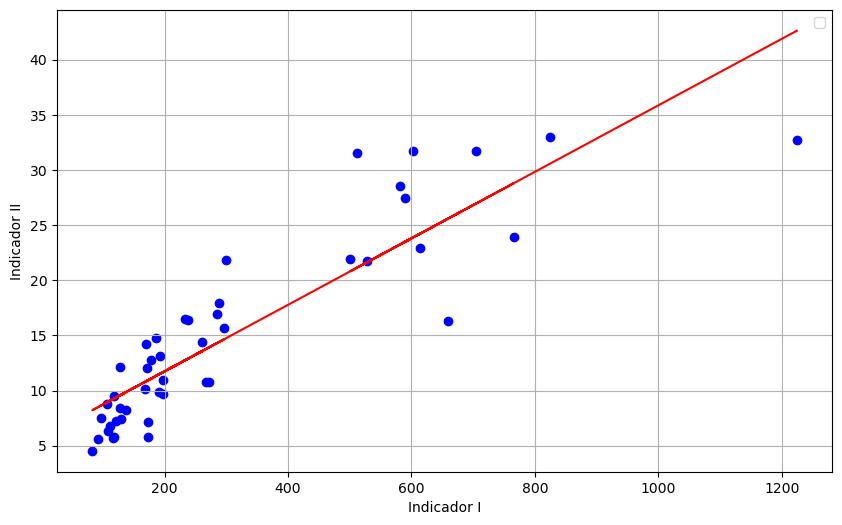

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = word_frec.values
y = df["Total"].values
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')
plt.plot(x, m * x + b, color='red')
plt.xlabel('Indicador I')
plt.ylabel('Indicador II')
plt.legend()
plt.grid()
plt.show()

In [18]:
correlacion_pearson = word_frec.corr(df["Total"], method='pearson')
correlacion_spearman = word_frec.corr(df["Total"], method='spearman')
print(f"Correlación de Pearson: {correlacion_pearson}")
print(f"Correlación de Spearman: {correlacion_spearman}")

Correlación de Pearson: 0.8812295201169433
Correlación de Spearman: 0.902436016034536


#### Descripción
Observamos una tendencia completamente ascendente. Las cifras actuales son sorprendentemente altas (~35%), teniendo en cuenta que se cuentan como frases oraciones cortas como: "Gracias."

### Enfoque por partidos

Repetimos la misma operación segregando por partidos.

La frecuencia total tenida en cuenta es respecto del número total de palabras de cada partido. 

In [19]:
## Elegimos los colores que representan a cada partido

colors = {
    "PP": "blue",
    "PSOE": "red",
    "VOX": "#008080",
    "IU-PODEMOS-+": "pink"
}

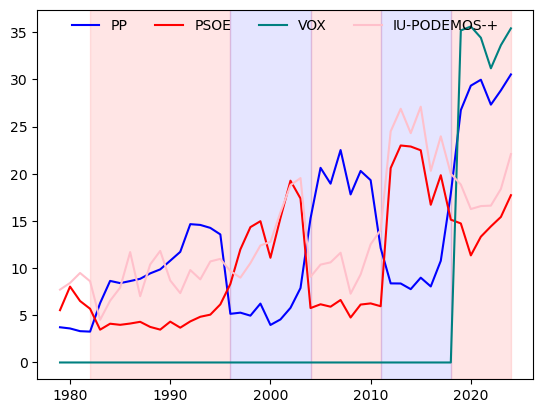

In [21]:
plt.legend(
    handles=[
        plt.Line2D([0], [0], color=color, label=label)
        for label, color in colors.items()
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.01), 
    ncol=len(colors),
    frameon=False
)


plt.plot(years, df["PP"], c=colors["PP"])
plt.plot(years, df["PSOE"], c=colors["PSOE"])
plt.plot(years, df["VOX"], c=colors["VOX"])
plt.plot(years, df["IU-PODEMOS"], c=colors["IU-PODEMOS-+"])

plt.axvspan(1982, 1996, color='red', alpha=0.1, label='Sombreado')
plt.axvspan(1996, 2004, color='blue', alpha=0.1, label='Sombreado')
plt.axvspan(2004, 2011, color='red', alpha=0.1, label='Sombreado')
plt.axvspan(2011, 2018, color='blue', alpha=0.1, label='Sombreado')
plt.axvspan(2018, 2024, color='red', alpha=0.1, label='Sombreado')

#### Descripción

En esta gráfica se presenta la misma tendencia ascendente que en la anterior.

Se observa la alternancia entre el los grupos de izquierdas y derechas. Las franjas rojas y azules representan al partido en el gobierno. El aumento y descenso del tanto por ciento de acusaciones coincide de forma milimétrica con el cambio de gobierno.

De forma menos clara, parece que este cambio comienza un poco antes del cambio de gobierno. La última linea vertical representa 2023, el año de las últimas elecciones. Previo a las elecciones, hay un descenso en los partidos de derechas. Podría explicarse este descenso como una anticipación a un cambio de gobierno favorable a estos partidos, dado que eran los favoritos en las encuestas.

Este último apunte es fundamental, pues si esta hipótesis fuera cierta, esta metodología podría ser aplicada para predecir resultados electorales de forma análoga a las encuestas. 

In [12]:
colors = {
    "Hombres": "blue",
    "Mujeres": "red"
}

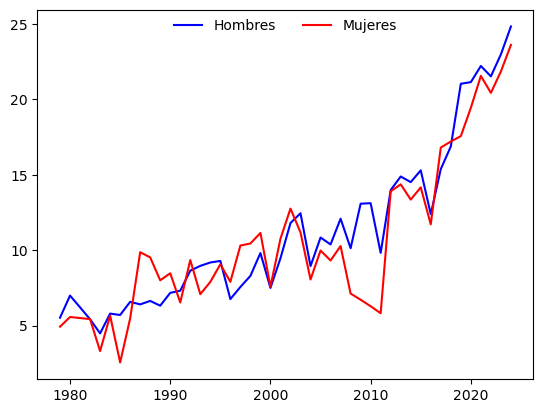

In [13]:
plt.legend(
    handles=[
        plt.Line2D([0], [0], color=color, label=label)
        for label, color in colors.items()
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.01), 
    ncol=len(colors),
    frameon=False
)

plt.plot(years, df["Total - Male"], c=colors["Hombres"])
plt.plot(years, df["Total - Female"], c=colors["Mujeres"])

#### Descripción
Observamos que el comportamiento de hombres y mujeres es homogéneo. En el intervalo entre ~2005 y ~2012 los hombres superan a las mujeres por 10 puntos porcentuales.